<a href="https://colab.research.google.com/github/abhay732001/quantium-data-analytics/blob/main/quantium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as mtp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from scipy.spatial.distance import cdist

In [2]:
from google.colab import files
uploaded=files.upload()

Saving QVI_transaction_data.csv to QVI_transaction_data.csv


In [3]:
import io
df2=pd.read_csv(io.BytesIO(uploaded['QVI_transaction_data.csv']))

In [4]:
#from google.colab import files
uploaded=files.upload()

Saving QVI_purchase_behaviour.csv to QVI_purchase_behaviour.csv


In [6]:
import io
df3=pd.read_csv(io.BytesIO(uploaded['QVI_purchase_behaviour.csv']))

In [7]:
left_merge=pd.merge(df2,df3,on='LYLTY_CARD_NBR',how='left')

In [8]:
left_merge=left_merge.rename(columns={";p;":"DATE"})


In [9]:
# import datetime
# for i in left_merge['DATE']:
#   left_merge['DATE'] = datetime.datetime.fromtimestamp(43390)
#   print(left_merge['DATE'].strftime('%Y-%m-%d %H:%M:%S'))
# left_merge['DATE']=  pd.to_datetime(left_merge['DATE'], format='%d%b%Y:%H:%M:%S.%f')
from datetime import date, timedelta
start = date(1899,12,30)

new_date_format = []

for date in left_merge["DATE"]:
    delta = timedelta(date)
    new_date_format.append(start + delta)

In [10]:
left_merge["DATE"]=pd.to_datetime(pd.Series(new_date_format))
print(left_merge["DATE"].dtype)

datetime64[ns]


In [11]:
left_merge["PROD_NAME"].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [12]:
split_prods = left_merge["PROD_NAME"].str.replace(r'([0-9]+[gG])','').str.replace(r'[^\w]', ' ').str.split()

In [13]:
word_counts = {}

def count_words(line):
    for word in line:
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1
            
split_prods.apply(lambda line: count_words(line))
print(pd.Series(word_counts).sort_values(ascending=False))

Chips      49770
Kettle     41288
Smiths     28860
Salt       27976
Cheese     27890
           ...  
Whlegrn     1432
Pc          1431
NCC         1419
Garden      1419
Fries       1418
Length: 198, dtype: int64


In [14]:
left_merge = left_merge[~left_merge["PROD_NAME"].str.contains(r"[Ss]alsa")]

In [15]:

print(left_merge.describe(), '\n')
print(left_merge.info())

           STORE_NBR  LYLTY_CARD_NBR  ...       PROD_QTY      TOT_SALES
count  246742.000000    2.467420e+05  ...  246742.000000  246742.000000
mean      135.051098    1.355310e+05  ...       1.908062       7.321322
std        76.787096    8.071528e+04  ...       0.659831       3.077828
min         1.000000    1.000000e+03  ...       1.000000       1.700000
25%        70.000000    7.001500e+04  ...       2.000000       5.800000
50%       130.000000    1.303670e+05  ...       2.000000       7.400000
75%       203.000000    2.030840e+05  ...       2.000000       8.800000
max       272.000000    2.373711e+06  ...     200.000000     650.000000

[8 rows x 6 columns] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246742 non-null  datetime64[ns]
 1   STORE_NBR         246742 non-null  int64       

In [16]:
left_merge["PROD_QTY"].value_counts(bins=4).sort_index()

(0.8, 50.75]       246740
(50.75, 100.5]          0
(100.5, 150.25]         0
(150.25, 200.0]         2
Name: PROD_QTY, dtype: int64

In [17]:
left_merge.sort_values(by="PROD_QTY",ascending=False).head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,OLDER FAMILIES,Premium
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,OLDER FAMILIES,Premium
135225,2019-05-15,46,46296,42138,81,Pringles Original Crisps 134g,5,18.5,RETIREES,Budget
69523,2019-05-15,71,71142,69852,96,WW Original Stacked Chips 160g,5,9.5,OLDER FAMILIES,Premium
69502,2018-08-18,55,55144,49328,44,Thins Chips Light& Tangy 175g,5,16.5,OLDER FAMILIES,Premium


In [18]:
left_merge = left_merge[left_merge["PROD_QTY"] < 6]

In [19]:
left_merge["DATE"].describe()

count                  246740
unique                    364
top       2018-12-24 00:00:00
freq                      865
first     2018-07-01 00:00:00
last      2019-06-30 00:00:00
Name: DATE, dtype: object

In [20]:
pd.date_range(start=left_merge["DATE"].min(), end=left_merge["DATE"].max()).difference(left_merge["DATE"])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [21]:
check_null_date = pd.merge(pd.Series(pd.date_range(start=left_merge["DATE"].min(), end=left_merge["DATE"].max()), name="DATE"), 
                           left_merge, on="DATE", how="left")

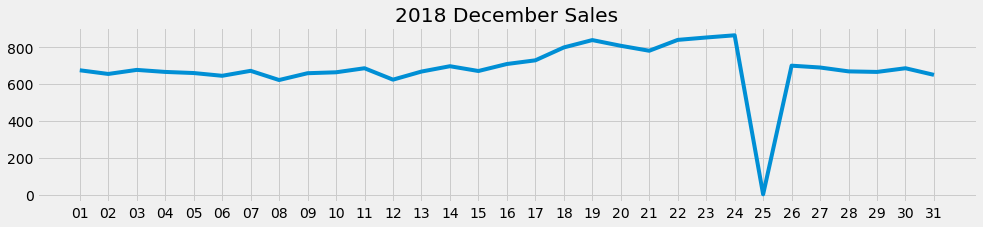

In [22]:
trans_by_date = check_null_date["DATE"].value_counts()
dec = trans_by_date[(trans_by_date.index >= pd.datetime(2018,12,1)) & (trans_by_date.index < pd.datetime(2019,1,1))].sort_index()
dec.index = dec.index.strftime('%d')
ax = dec.plot(figsize=(15,3))
ax.set_xticks(np.arange(len(dec)))
ax.set_xticklabels(dec.index)
plt.title("2018 December Sales")
plt.savefig("2018 December Sales.png", bbox_inches="tight")
plt.show()

In [23]:
check_null_date["DATE"].value_counts().sort_values().head()

2018-12-25      1
2019-06-13    607
2018-09-22    609
2018-11-25    610
2018-10-18    611
Name: DATE, dtype: int64

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: 0, dtype: float64


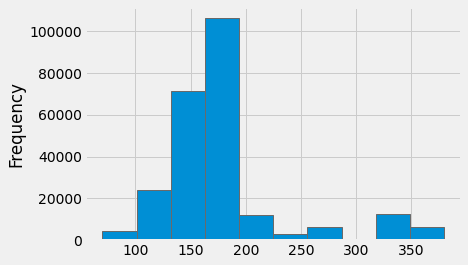

In [24]:
left_merge["PROD_NAME"] = left_merge["PROD_NAME"].str.replace(r'(G)','g')
pack_sizes = left_merge["PROD_NAME"].str.extract(r'([0-9]+[gG])')[0].str.replace("g","").astype("float")
print(pack_sizes.describe())
pack_sizes.plot.hist()

In [25]:
left_merge["PROD_NAME"].str.split().str[0].value_counts().sort_index()

Burger         1564
CCs            4551
Cheetos        2927
Cheezels       4603
Cobs           9693
Dorito         3183
Doritos       22041
French         1418
Infuzions     11057
Infzns         3144
Kettle        41288
NCC            1419
Natural        6050
Pringles      25102
RRD           11894
Red            4427
Smith          2963
Smiths        27390
Snbts          1576
Sunbites       1432
Thins         14075
Tostitos       9471
Twisties       9454
Tyrrells       6442
WW            10320
Woolworths     1516
grain          6272
grnWves        1468
Name: PROD_NAME, dtype: int64

In [26]:
left_merge["PROD_NAME"].str.split()[left_merge["PROD_NAME"].str.split().str[0] == "Grain"].value_counts()

Series([], Name: PROD_NAME, dtype: int64)

In [ ]:
tuple(left_merge["PROD_NAME"].str.split()[left_merge["PROD_NAME"].str.split().str[0] == "Natural"],count_words)

TypeError: ignored

In [ ]:
left_merge["PROD_NAME"].str.split()[left_merge["PROD_NAME"].str.split().str[0] == "Red"].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Red, Rock, Deli, Sp, Salt, &, Truffle, 150g]    1498
[Red, Rock, Deli, Thai, Chilli&Lime, 150g]       1495
[Red, Rock, Deli, Chikn&garlic, Aioli, 150g]     1434
Name: PROD_NAME, dtype: int64

In [27]:
left_merge["Cleaned_Brand_Names"] = left_merge["PROD_NAME"].str.split().str[0]

In [28]:
def clean_brand_names(line):
  brand = line["Cleaned_Brand_Names"]
  if brand=="Doritos":
    return "Doritos"
  elif brand == "GrnWves" or brand == "Grain":
    return "Grain Waves"
  elif brand == "Infzns":
    return "Infuzions"
  elif brand == "Natural" or brand == "NCC":
    return "Natural Chip Co"
  elif brand == "Red":
    return "RRD"
  elif brand == "Smith":
    return "Smiths"
  elif brand == "Snbts":
    return "Sunbites"
  elif brand == "WW":
    return "Woolworths"
  else:
    return brand

In [29]:
left_merge["Cleaned_Brand_Names"] = left_merge.apply(lambda line: clean_brand_names(line), axis=1)

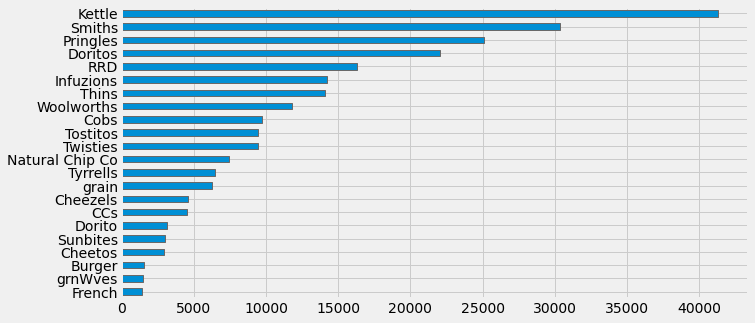

In [30]:
left_merge["Cleaned_Brand_Names"].value_counts(ascending=True).plot.barh(figsize=(10,5))

In [31]:
left_merge.isnull().sum()

DATE                   0
STORE_NBR              0
LYLTY_CARD_NBR         0
TXN_ID                 0
PROD_NBR               0
PROD_NAME              0
PROD_QTY               0
TOT_SALES              0
LIFESTAGE              0
PREMIUM_CUSTOMER       0
Cleaned_Brand_Names    0
dtype: int64

In [32]:
left_merge.to_csv(r'A:\codes\quantium data analysis.csv', index=False)

In [33]:
grouped_sales = pd.DataFrame(left_merge.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].agg(["sum", "mean"]))
grouped_sales.sort_values(ascending=False, by="sum")

sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Mainstream        145168.95  7.269352
YOUNG FAMILIES         Budget            129717.95  7.302705
OLDER SINGLES/COUPLES  Budget            127833.60  7.444305
                       Mainstream        124648.50  7.306049
                       Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Premium            91296.65  7.461315
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Premium            75242.60  7.232779
YOUNG SINGLES/COUPLES  Budget             57122.10  6.663023
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
MIDAGE SINGLES/COUPLES Budget             33345.70  7.108442
NEW FAMILIES           Budget             20607.45  7.297256
                       Mainstream         15979.70  7.313364
                       Premium            10760.80  7.231720

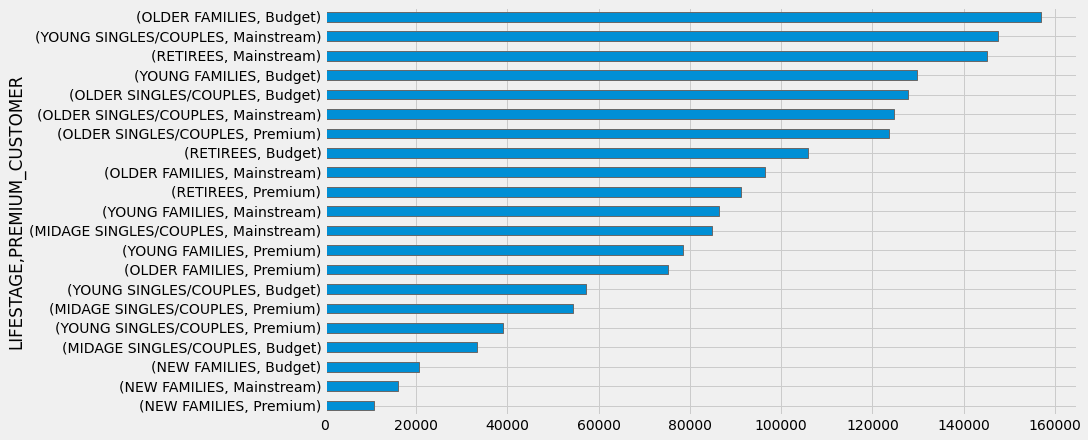

In [34]:
grouped_sales["sum"].sort_values().plot.barh(figsize=(12,7))

TypeError: ignored

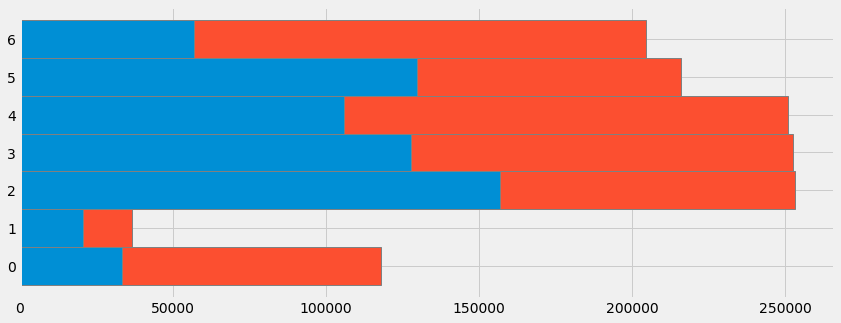

In [35]:
bars1 = grouped_sales[grouped_sales.index.get_level_values("PREMIUM_CUSTOMER") == "Budget"]["sum"]
bars2 = grouped_sales[grouped_sales.index.get_level_values("PREMIUM_CUSTOMER") == "Mainstream"]["sum"]
bars3 = grouped_sales[grouped_sales.index.get_level_values("PREMIUM_CUSTOMER") == "Premium"]["sum"]
 
bars1_text = (bars1 / sum(grouped_sales["sum"])).apply("{:.1%}".format)
bars2_text = (bars2 / sum(grouped_sales["sum"])).apply("{:.1%}".format)
bars3_text = (bars3 / sum(grouped_sales["sum"])).apply("{:.1%}".format)
 
# Names of group and bar width
names = grouped_sales.index.get_level_values("LIFESTAGE").unique()

# The position of the bars on the x-axis
r = np.arange(len(names))

plt.figure(figsize=(13,5)) 

# Create brown bars
budget_bar = plt.barh(r, bars1, edgecolor='grey', height=1, label="Budget")
# Create green bars (middle), on top of the firs ones
mains_bar = plt.barh(r, bars2, left=bars1, edgecolor='grey', height=1, label="Mainstream")
# Create green bars (top)
prem_bar = plt.barh(r, bars3, left= np.add(bars2+bars1), edgecolor='grey', height=1, label="Premium")
    
for i in range(7):
    budget_width = budget_bar[i].get_width()
    budget_main_width = budget_width + mains_bar[i].get_width()
    #budget_prem_width= budget_main_width+prem_bar[i].get_width()
    plt.text(budget_width/2, i, bars1_text[i], va='center', ha='center', size=8)
    plt.text(budget_width + mains_bar[i].get_width()/2, i, bars2_text[i], va='center', ha='center', size=8)
    plt.text(budget_main_width + prem_bar[i].get_width()/2, i, bars3_text[i], va='center', ha='center', size=8)
    
# Custom X axis
plt.yticks(r, names)
plt.ylabel("LIFESTAGE")
plt.xlabel("TOTAL SALES")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Total Sales per Lifestage")

plt.savefig("lifestage_sales.png", bbox_inches="tight")

# Show graphic
plt.show()

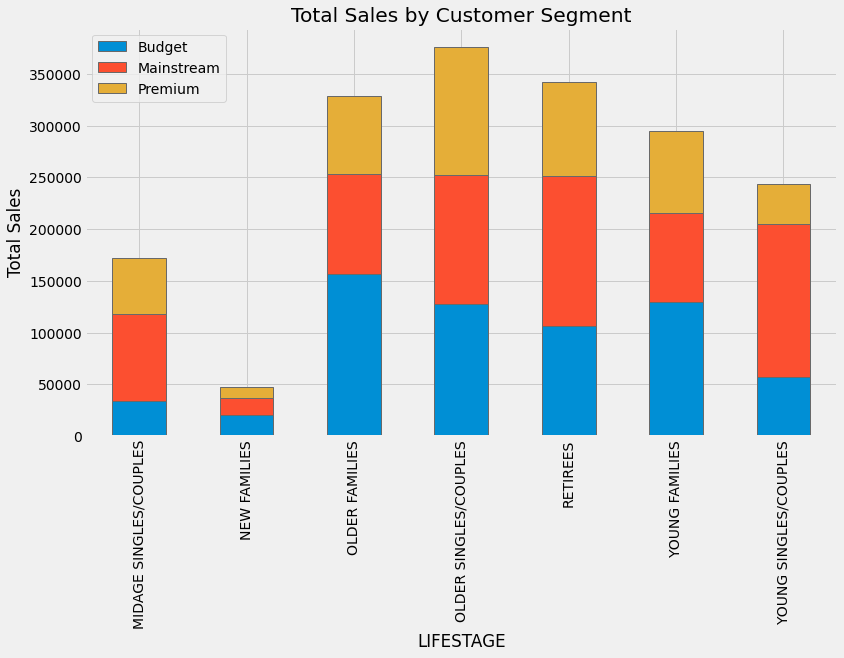

In [36]:
salesPlot = pd.DataFrame(left_merge.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [37]:
stage_agg_prem = left_merge.groupby("LIFESTAGE")["PREMIUM_CUSTOMER"].agg(pd.Series.mode).sort_values()
print("Top contributor per LIFESTAGE by PREMIUM category")
print(stage_agg_prem)

Top contributor per LIFESTAGE by PREMIUM category
LIFESTAGE
NEW FAMILIES                  Budget
OLDER FAMILIES                Budget
OLDER SINGLES/COUPLES         Budget
YOUNG FAMILIES                Budget
MIDAGE SINGLES/COUPLES    Mainstream
RETIREES                  Mainstream
YOUNG SINGLES/COUPLES     Mainstream
Name: PREMIUM_CUSTOMER, dtype: object


In [38]:
unique_cust = left_merge.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique().sort_values(ascending=False)
pd.DataFrame(unique_cust)

LYLTY_CARD_NBR
LIFESTAGE              PREMIUM_CUSTOMER                
YOUNG SINGLES/COUPLES  Mainstream                  7917
RETIREES               Mainstream                  6358
OLDER SINGLES/COUPLES  Mainstream                  4858
                       Budget                      4849
                       Premium                     4682
OLDER FAMILIES         Budget                      4611
RETIREES               Budget                      4385
YOUNG FAMILIES         Budget                      3953
RETIREES               Premium                     3812
YOUNG SINGLES/COUPLES  Budget                      3647
MIDAGE SINGLES/COUPLES Mainstream                  3298
OLDER FAMILIES         Mainstream                  2788
YOUNG FAMILIES         Mainstream                  2685
YOUNG SINGLES/COUPLES  Premium                     2480
YOUNG FAMILIES         Premium                     2398
MIDAGE SINGLES/COUPLES Premium                     2369
OLDER FAMILIES         Premium                     2231
MIDAGE SINGLES/COUPLES Budget                      1474
NEW FAMILIES           Budget                      1087
                       Mainstream                   830
                       Premium                      575

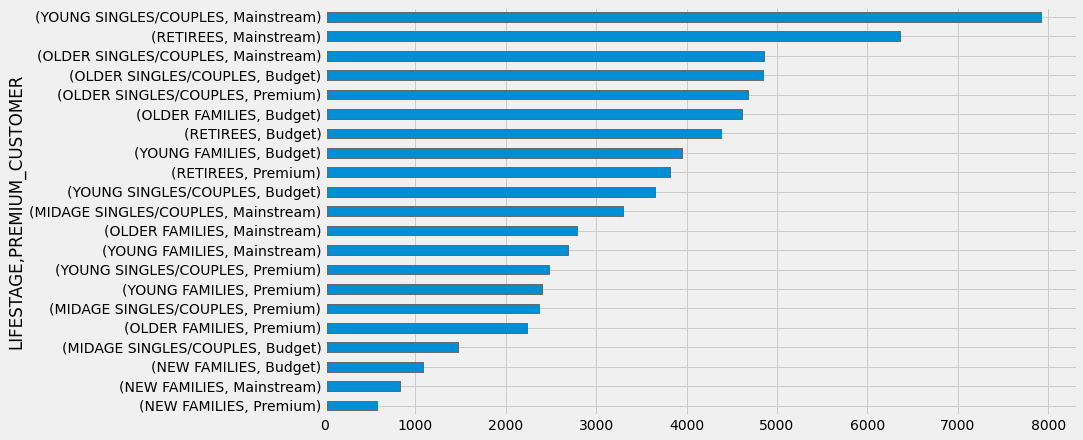

In [39]:
unique_cust.sort_values().plot.barh(figsize=(12,7))

In [40]:
avg_units = left_merge.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / left_merge.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


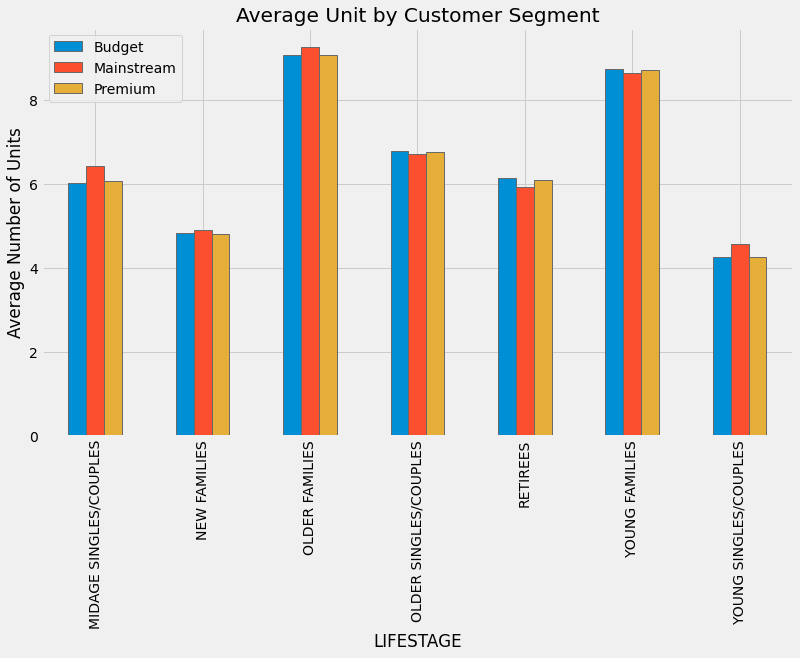

In [41]:
avgUnitsPlot = pd.DataFrame(left_merge.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / left_merge.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [42]:
avg_price = left_merge.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / left_merge.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.074043
                 MIDAGE SINGLES/COUPLES        3.994449
                 NEW FAMILIES                  3.935887
Budget           RETIREES                      3.932731
                 NEW FAMILIES                  3.931969

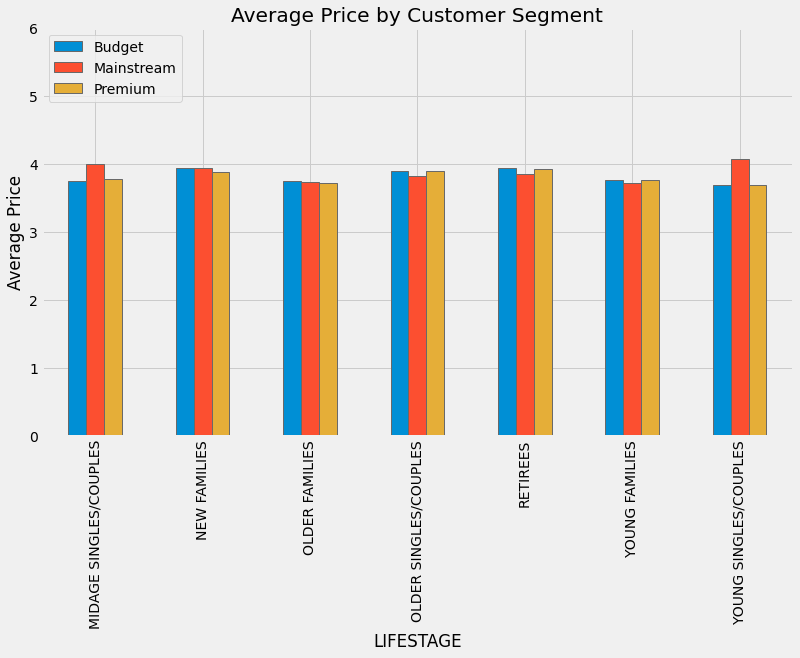

In [43]:
avgPricePlot = pd.DataFrame(left_merge.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / left_merge.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [44]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

# Create a new dataframe pricePerUnit
pricePerUnit = left_merge

# Create a new column under pricePerUnit called PRICE
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Cleaned_Brand_Names,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,Natural Chip Co,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,CCs,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,Smiths,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,Smiths,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,Kettle,4.60


In [45]:
mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

Text(0.5, 0, 'Price per Unit')

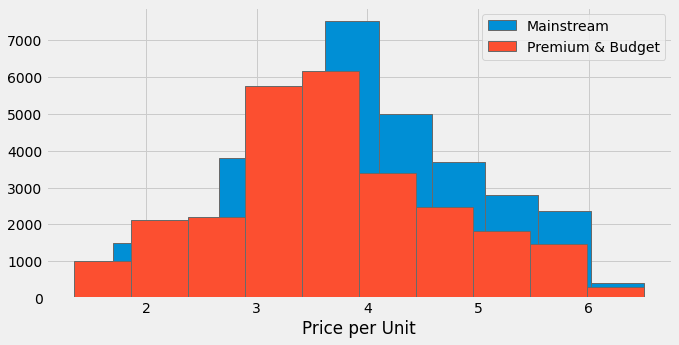

In [46]:

plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')


In [47]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-mainstream average price per unit: ${:.2f}".format(np.mean(nonMainstream)))
if np.mean(mainstream) > np.mean(nonMainstream):
    print("Mainstream customers have higher average price per unit. ")
else:
    print("Non-mainstream customers have a higher average price per unit. ")

Mainstream average price per unit: $4.04
Non-mainstream average price per unit: $3.71
Mainstream customers have higher average price per unit. 


In [48]:
from scipy.stats import ttest_ind
ttest_ind(mainstream, nonMainstream)

Ttest_indResult(statistic=37.83196107667815, pvalue=2.235645611549355e-309)

In [49]:
target = left_merge.loc[(left_merge['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (left_merge['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = left_merge.loc[(left_merge['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (left_merge['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Cleaned_Brand_Names,PRICE
237702,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag&Sauce 150g,1,2.6,YOUNG SINGLES/COUPLES,Mainstream,Smiths,2.6
237703,2018-08-17,1,1163,188,46,Kettle Original 175g,1,5.4,YOUNG SINGLES/COUPLES,Mainstream,Kettle,5.4
237704,2018-08-14,1,1291,333,27,WW Supreme Cheese Corn Chips 200g,1,1.9,YOUNG SINGLES/COUPLES,Mainstream,Woolworths,1.9
237705,2019-05-15,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag 380g,1,5.9,YOUNG SINGLES/COUPLES,Mainstream,Smiths,5.9
237706,2019-05-18,3,3118,1574,62,Pringles Mystery Flavour 134g,1,3.7,YOUNG SINGLES/COUPLES,Mainstream,Pringles,3.7


In [50]:
left_merge.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["Cleaned_Brand_Names"].agg(pd.Series.mode).sort_values()


LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              Kettle
YOUNG SINGLES/COUPLES   Budget              Kettle
YOUNG FAMILIES          Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
RETIREES                Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
OLDER SINGLES/COUPLES   Premium             Kettle
YOUNG SINGLES/COUPLES   Mainstream          Kettle
OLDER SINGLES/COUPLES   Mainstream          Kettle
OLDER FAMILIES          Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
NEW FAMILIES            Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
MIDAGE SINGLES/COUPLES  Premium             Kettle
                        Mainstream       

========== YOUNG SINGLES/COUPLES - Premium ==========
Kettle      838
Smiths      787
Pringles    537
Name: Cleaned_Brand_Names, dtype: int64


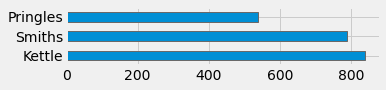

========== YOUNG SINGLES/COUPLES - Budget ==========
Kettle      1211
Smiths      1185
Pringles     832
Name: Cleaned_Brand_Names, dtype: int64


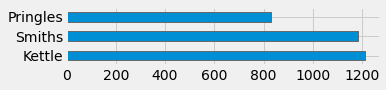

========== YOUNG SINGLES/COUPLES - Mainstream ==========
Kettle      3844
Pringles    2315
Doritos     2076
Name: Cleaned_Brand_Names, dtype: int64


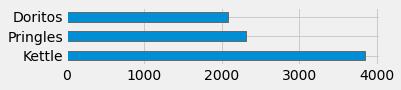

========== MIDAGE SINGLES/COUPLES - Premium ==========
Kettle      1206
Smiths       923
Pringles     781
Name: Cleaned_Brand_Names, dtype: int64


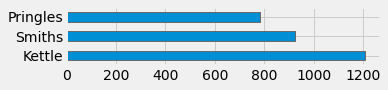

========== MIDAGE SINGLES/COUPLES - Budget ==========
Kettle      713
Smiths      591
Pringles    449
Name: Cleaned_Brand_Names, dtype: int64


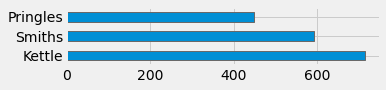

========== MIDAGE SINGLES/COUPLES - Mainstream ==========
Kettle      2136
Smiths      1276
Pringles    1159
Name: Cleaned_Brand_Names, dtype: int64


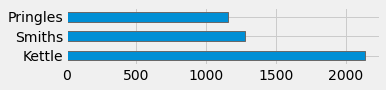

========== NEW FAMILIES - Premium ==========
Kettle      247
Pringles    165
Smiths      155
Name: Cleaned_Brand_Names, dtype: int64


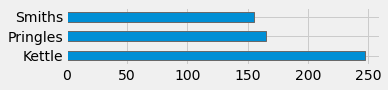

========== NEW FAMILIES - Budget ==========
Kettle      510
Smiths      328
Pringles    309
Name: Cleaned_Brand_Names, dtype: int64


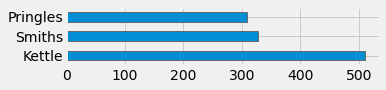

========== NEW FAMILIES - Mainstream ==========
Kettle      414
Smiths      244
Pringles    224
Name: Cleaned_Brand_Names, dtype: int64


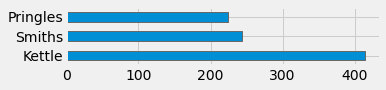

========== OLDER FAMILIES - Premium ==========
Kettle      1512
Smiths      1448
Pringles    1014
Name: Cleaned_Brand_Names, dtype: int64


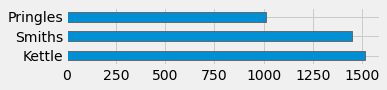

========== OLDER FAMILIES - Budget ==========
Kettle      3320
Smiths      2948
Pringles    1996
Name: Cleaned_Brand_Names, dtype: int64


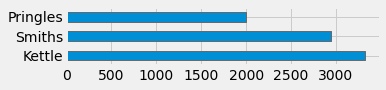

========== OLDER FAMILIES - Mainstream ==========
Kettle      2019
Smiths      1742
Pringles    1234
Name: Cleaned_Brand_Names, dtype: int64


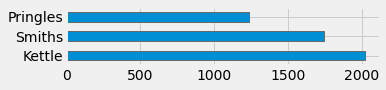

========== OLDER SINGLES/COUPLES - Premium ==========
Kettle      2947
Smiths      1952
Pringles    1744
Name: Cleaned_Brand_Names, dtype: int64


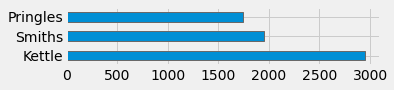

========== OLDER SINGLES/COUPLES - Budget ==========
Kettle      3065
Smiths      2010
Pringles    1843
Name: Cleaned_Brand_Names, dtype: int64


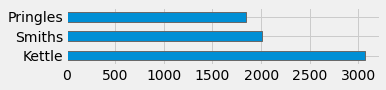

========== OLDER SINGLES/COUPLES - Mainstream ==========
Kettle      2835
Smiths      2070
Pringles    1720
Name: Cleaned_Brand_Names, dtype: int64


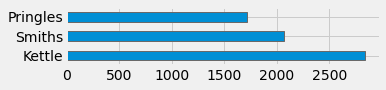

========== RETIREES - Premium ==========
Kettle      2216
Smiths      1395
Pringles    1331
Name: Cleaned_Brand_Names, dtype: int64


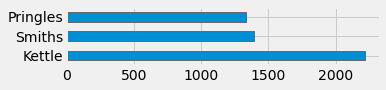

========== RETIREES - Budget ==========
Kettle      2592
Smiths      1612
Pringles    1517
Name: Cleaned_Brand_Names, dtype: int64


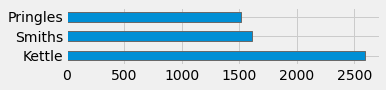

========== RETIREES - Mainstream ==========
Kettle      3386
Smiths      2367
Pringles    2103
Name: Cleaned_Brand_Names, dtype: int64


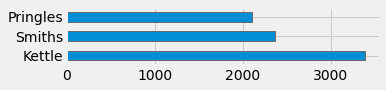

========== YOUNG FAMILIES - Premium ==========
Kettle      1745
Smiths      1384
Pringles    1007
Name: Cleaned_Brand_Names, dtype: int64


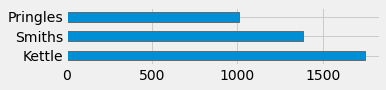

========== YOUNG FAMILIES - Budget ==========
Kettle      2743
Smiths      2334
Pringles    1674
Name: Cleaned_Brand_Names, dtype: int64


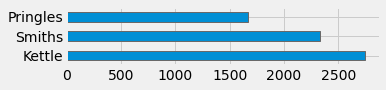

========== YOUNG FAMILIES - Mainstream ==========
Kettle      1789
Smiths      1681
Pringles    1148
Name: Cleaned_Brand_Names, dtype: int64


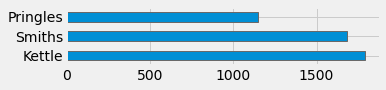

In [52]:
for stage in left_merge["LIFESTAGE"].unique():
    for prem in left_merge["PREMIUM_CUSTOMER"].unique():
        print('==========',stage, '-', prem,'==========')
        summary = left_merge[(left_merge["LIFESTAGE"] == stage) & (left_merge["PREMIUM_CUSTOMER"] == prem)]["Cleaned_Brand_Names"].value_counts().head(3)
        print(summary)
        plt.figure()
        summary.plot.barh(figsize=(5,1))
        plt.show()

In [53]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [55]:
temp = left_merge.reset_index().rename(columns = {"index": "transaction"})
temp["Segment"] = temp["LIFESTAGE"] + ' - ' + temp['PREMIUM_CUSTOMER']
segment_brand_encode = pd.concat([pd.get_dummies(temp["Segment"]), pd.get_dummies(temp["Cleaned_Brand_Names"])], axis=1)

In [56]:
frequent_sets = apriori(segment_brand_encode, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_sets, metric="lift", min_threshold=1)

In [57]:
set_temp = temp["Segment"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(OLDER FAMILIES - Budget),(Smiths),0.087193,0.123016,0.011948,0.137027,1.113895,0.001222,1.016236
3,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069596,0.167334,0.012422,0.178488,1.066658,0.000776,1.013578
5,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067115,0.167334,0.011944,0.177959,1.063495,0.000713,1.012925
7,(RETIREES - Budget),(Kettle),0.057652,0.167334,0.010505,0.182214,1.088926,0.000858,1.018196
8,(RETIREES - Mainstream),(Kettle),0.080935,0.167334,0.013723,0.169554,1.013269,0.000180,1.002674
10,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537


========== YOUNG SINGLES/COUPLES - Premium ==========
134.0     537
150.0     933
175.0    1618
Name: Pack_Size, dtype: int64


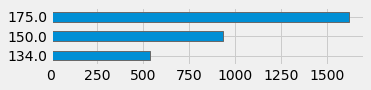

========== YOUNG SINGLES/COUPLES - Budget ==========
134.0     832
150.0    1390
175.0    2338
Name: Pack_Size, dtype: int64


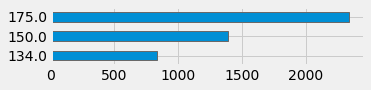

========== YOUNG SINGLES/COUPLES - Mainstream ==========
134.0    2315
150.0    3080
175.0    4997
Name: Pack_Size, dtype: int64


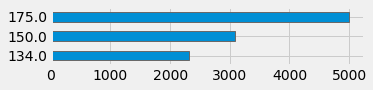

========== MIDAGE SINGLES/COUPLES - Premium ==========
134.0     781
150.0    1207
175.0    2082
Name: Pack_Size, dtype: int64


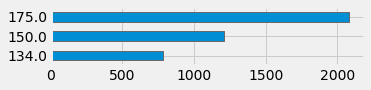

========== MIDAGE SINGLES/COUPLES - Budget ==========
134.0     449
150.0     771
175.0    1277
Name: Pack_Size, dtype: int64


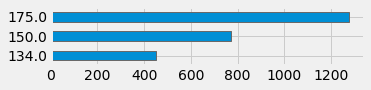

========== MIDAGE SINGLES/COUPLES - Mainstream ==========
134.0    1159
150.0    1777
175.0    2975
Name: Pack_Size, dtype: int64


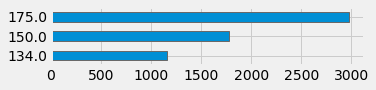

========== NEW FAMILIES - Premium ==========
134.0    165
150.0    233
175.0    376
Name: Pack_Size, dtype: int64


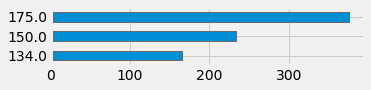

========== NEW FAMILIES - Budget ==========
134.0    309
150.0    440
175.0    777
Name: Pack_Size, dtype: int64


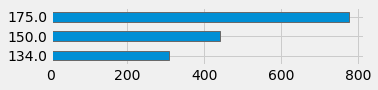

========== NEW FAMILIES - Mainstream ==========
134.0    224
150.0    374
175.0    589
Name: Pack_Size, dtype: int64


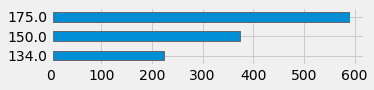

========== OLDER FAMILIES - Premium ==========
134.0    1014
150.0    1673
175.0    2816
Name: Pack_Size, dtype: int64


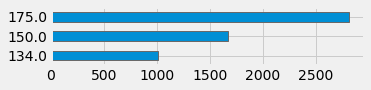

========== OLDER FAMILIES - Budget ==========
134.0    1996
150.0    3588
175.0    5808
Name: Pack_Size, dtype: int64


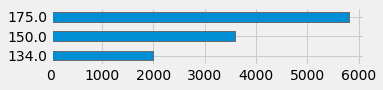

========== OLDER FAMILIES - Mainstream ==========
134.0    1234
150.0    2189
175.0    3588
Name: Pack_Size, dtype: int64


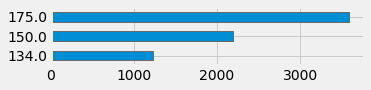

========== OLDER SINGLES/COUPLES - Premium ==========
134.0    1744
150.0    2768
175.0    4458
Name: Pack_Size, dtype: int64


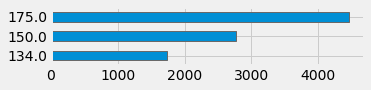

========== OLDER SINGLES/COUPLES - Budget ==========
134.0    1843
150.0    2811
175.0    4625
Name: Pack_Size, dtype: int64


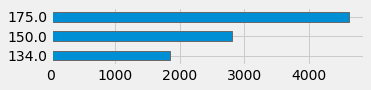

========== OLDER SINGLES/COUPLES - Mainstream ==========
134.0    1720
150.0    2773
175.0    4525
Name: Pack_Size, dtype: int64


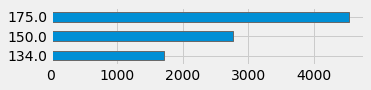

========== RETIREES - Premium ==========
134.0    1331
150.0    1943
175.0    3306
Name: Pack_Size, dtype: int64


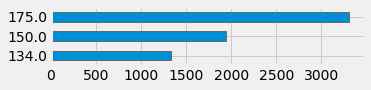

========== RETIREES - Budget ==========
134.0    1517
150.0    2319
175.0    3847
Name: Pack_Size, dtype: int64


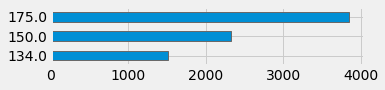

========== RETIREES - Mainstream ==========
134.0    2103
150.0    3290
175.0    5295
Name: Pack_Size, dtype: int64


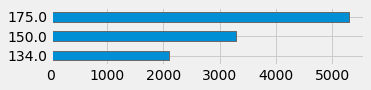

========== YOUNG FAMILIES - Premium ==========
134.0    1007
150.0    1778
175.0    2998
Name: Pack_Size, dtype: int64


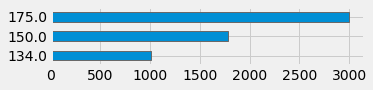

========== YOUNG FAMILIES - Budget ==========
134.0    1674
150.0    2862
175.0    4921
Name: Pack_Size, dtype: int64


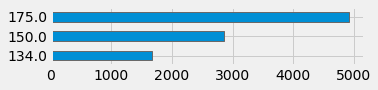

========== YOUNG FAMILIES - Mainstream ==========
134.0    1148
150.0    2004
175.0    3174
Name: Pack_Size, dtype: int64


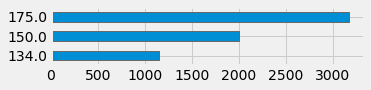

In [60]:
merged_pack = pd.concat([left_merge, pack_sizes.rename("Pack_Size")], axis=1)

for stage in left_merge["LIFESTAGE"].unique():
    for prem in left_merge["PREMIUM_CUSTOMER"].unique():
        print('==========',stage, '-', prem,'==========')
        summary = merged_pack[(merged_pack["LIFESTAGE"] == stage) & (merged_pack["PREMIUM_CUSTOMER"] == prem)]["Pack_Size"].value_counts().head(3).sort_index()
        print(summary)
        plt.figure()
        summary.plot.barh(figsize=(5,1))
        plt.show()

In [ ]:
(temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum() / temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique()).sort_values(ascending=False)

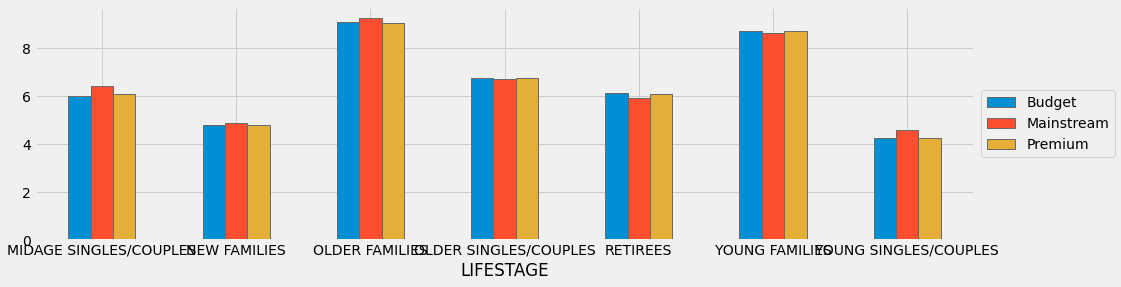

In [61]:
(temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum() / temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique()).unstack().plot.bar(figsize=(15,4), rot=0)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.savefig("Average purchase quantity per segment.png", bbox_inches="tight")

In [62]:
#Average chips price per transaction by segments
temp["Unit_Price"] = temp["TOT_SALES"] / temp["PROD_QTY"]
temp.groupby(["Segment"]).mean()["Unit_Price"].sort_values(ascending=False)

Segment
YOUNG SINGLES/COUPLES - Mainstream     4.065642
MIDAGE SINGLES/COUPLES - Mainstream    3.994241
RETIREES - Budget                      3.924404
RETIREES - Premium                     3.920942
NEW FAMILIES - Budget                  3.917688
NEW FAMILIES - Mainstream              3.916133
OLDER SINGLES/COUPLES - Premium        3.893182
OLDER SINGLES/COUPLES - Budget         3.882096
NEW FAMILIES - Premium                 3.872110
RETIREES - Mainstream                  3.844294
OLDER SINGLES/COUPLES - Mainstream     3.814665
MIDAGE SINGLES/COUPLES - Premium       3.770698
YOUNG FAMILIES - Premium               3.762150
YOUNG FAMILIES - Budget                3.760737
OLDER FAMILIES - Budget                3.745340
MIDAGE SINGLES/COUPLES - Budget        3.743328
OLDER FAMILIES - Mainstream            3.737077
YOUNG FAMILIES - Mainstream            3.724533
OLDER FAMILIES - Premium               3.717000
YOUNG SINGLES/COUPLES - Premium        3.665414
YOUNG SINGLES/COUPLES - Budget  

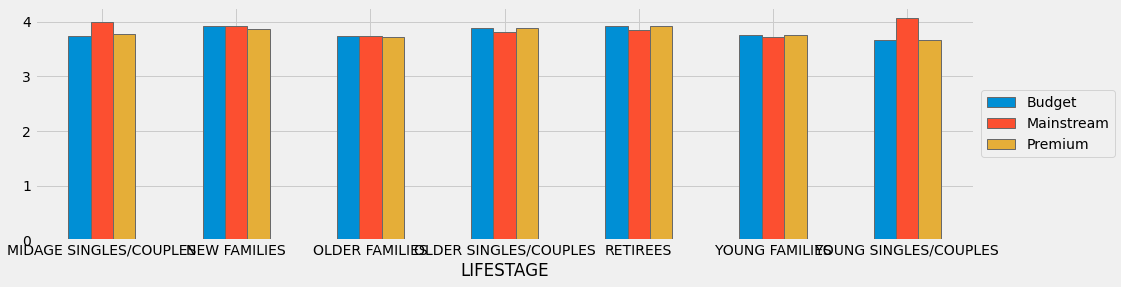

In [63]:
temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"]).mean()["Unit_Price"].unstack().plot.bar(figsize=(15,4), rot=0)
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))

In [64]:
z = temp.groupby(["Segment", "Cleaned_Brand_Names"]).sum()["TOT_SALES"].sort_values(ascending=False).reset_index()
z[z["Segment"] == "YOUNG SINGLES/COUPLES - Mainstream"]

,Segment,Cleaned_Brand_Names,TOT_SALES
0,YOUNG SINGLES/COUPLES - Mainstream,Kettle,35423.6
12,YOUNG SINGLES/COUPLES - Mainstream,Doritos,17266.4
17,YOUNG SINGLES/COUPLES - Mainstream,Pringles,16006.2
20,YOUNG SINGLES/COUPLES - Mainstream,Smiths,14958.9
52,YOUNG SINGLES/COUPLES - Mainstream,Infuzions,8749.4
59,YOUNG SINGLES/COUPLES - Mainstream,Twisties,7539.8
68,YOUNG SINGLES/COUPLES - Mainstream,Tostitos,7238.0
69,YOUNG SINGLES/COUPLES - Mainstream,Thins,7217.1
82,YOUNG SINGLES/COUPLES - Mainstream,Cobs,6144.6
115,YOUNG SINGLES/COUPLES - Mainstream,Tyrrells,4800.6
